In [1]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
from math import sqrt
from mpl_toolkits.mplot3d import Axes3D

eps = np.finfo(float).eps

def drawPerspective(handleax,input_matrix,title=None,cmap = "gray"):
    handleax.set_title(title)
    handleax.set_zlabel('Z')  # 坐标轴
    handleax.set_ylabel('Y')
    handleax.set_xlabel('X')
    x,y = input_matrix.shape
    X = np.arange(0,x,1)
    Y = np.arange(0,y,1)
    # 由于图像x,y坐标和 meshigrid出来是互反的
    # 这里需要调转一下
    # 否则会出现mismatch的现象
    X,Y = np.meshgrid(Y, X)
    handleax.plot_surface(Y, X, input_matrix, cmap=cmap)
#     handleax.plot_wireframe(Y, X, input_matrix, cmap=cmap)
def drawPanel(handleax,input_matrix,title=None,cmap = "gray"):
    handleax.set_title(title)
    handleax.set_ylabel('Y')
    handleax.set_xlabel('X')
    handleax.imshow(input_matrix,cmap = cmap)
def drawCurv(handleax,functions,labels,filter_d0,title=None,cmap = "gray"):
    # 绘制从0到 3D_0的函数剖面图
    handleax.set_title(title)
    handleax.set_xlabel("$D(u,v)$")
    handleax.set_ylabel("$H(u,v)$")
    # 标出D_0点
    # handleax.annotate(r"$D_0$", xy = (filter_d0,0) , weight='heavy')
    
    for func,lab in zip(functions,labels):
        # 对每一对func和label绘图 （针对需要画多条线的情况）
        X = np.arange(0,3*filter_d0+1,0.1)
        Y = func(X)
        handleax.plot(X,Y,label = lab)
    handleax.set_xticks([0,filter_d0])
    handleax.set_xticklabels(["$0$","$D_0$"])
    handleax.legend()
def frequencyToSpatial(input_matrix):
    # 这里不太明白为什么shift与否最后都需要添加一个fftshift来得到想要的空间域图像
    shift_input_matrix = np.fft.ifftshift(input_matrix)
#     shift_input_matrix = input_matrix
    spatial_img = np.abs(np.fft.ifft2(shift_input_matrix))
    spatial_img = np.fft.fftshift(spatial_img)
    return spatial_img


# 频率域滤波图像复原

在频率域滤波进行图像复原主要在两个方面效果较好，其一是利用频率域滤波消除周期噪声，另一个是利用频率域做退化函数的逆滤波，周期噪声还没有细致研究，这篇文章主要关注其逆滤波相关的问题。

为什么要在频率域做逆滤波？观察之前退化模型的两个式子，我们不难发现：

$$g(x,y) = h(x,y) \star f(x,y) + \eta(x,y)$$


$$g(u,v) = H(u,v) F(u,v) + N(u,v)$$

对(1)式空间域来说，想要从$g(x,y)$恢复$f(x,y)$，避不开的是“卷积”的逆运算，这在定义和实现的复杂上都比较困难，而转化到频率域，从(2)式我们或许可以通过一个“除法”来实现逆滤波，结合之前噪声模型相关内容，我们尝试在频率域上对仅退化函数影响的图像，和更复杂一些的，退化函数和加性噪声双重影响的图像进行复原。

## 估计退化函数

在图像复原时，主要有3种用于估计退化函数的方法：（1）观察法，（2）试验法，（3）数学建模法。这里我们着重讲建模估计。

1. 湍流模糊

    Hufnagel and Stanley[1964]根据大气湍流的物理特性提出了一个退化模型，其通式为：

    $$H(u,v) = e^{-k{(u^2+v^2)}^{5/6}}$$

    式中，$k$是与湍流性质有关的常熟。除了指数为$5/6$之外，该式与高斯低通及其相似。

    实现：

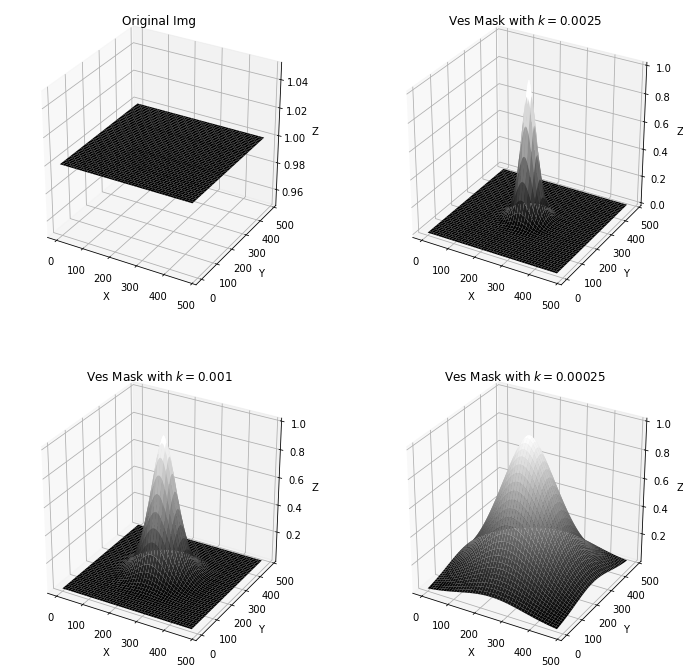

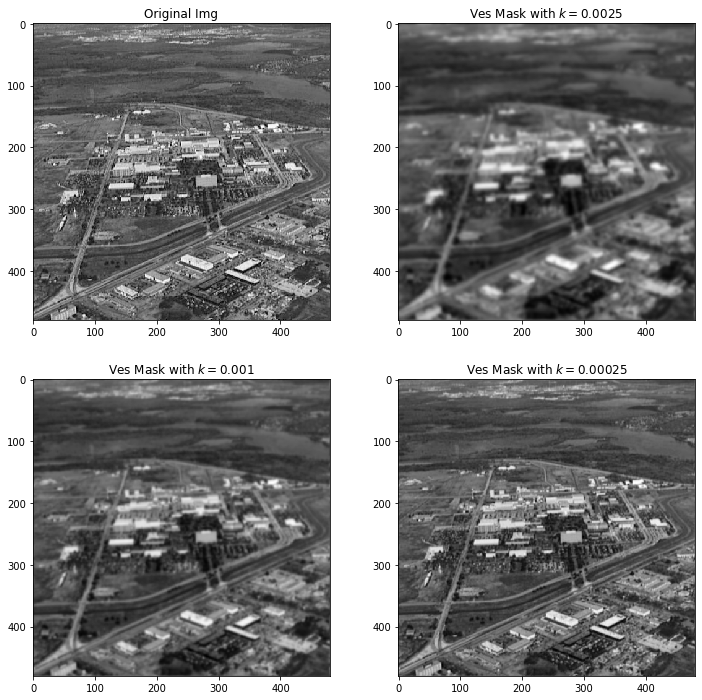

In [2]:
def getVesMask(mask_shape,k):
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols))
    for i in range(rows):
        for j in range(cols):
            dis = (i-crow)**2 + (j-ccol)**2
            mask[i,j] = np.exp(-k*(dis**(5/6)))
    return mask

def getVesFilterPassImg(input_img : np.array, k  , size = None):
    f_img = np.fft.fft2(input_img , s = size)
    shift_img = np.fft.fftshift(f_img)
    mask_shift_img = getVesMask(f_img.shape,k)
    new_shift_img = mask_shift_img*shift_img
    new_manitude_img = 20*np.log(np.abs(new_shift_img+eps))
    new_f_img = np.fft.ifftshift(new_shift_img)
    new_img = np.fft.ifft2(new_f_img)
    new_img = np.abs(new_img)
    return new_img

# 测试
# 参数设置
mask_shape = (480,480)
k = [0,0.0025,0.001,0.00025]
plt.figure(figsize=(12,12))
ax = [plt.subplot(221,projection = "3d"),plt.subplot(222,projection = "3d"),plt.subplot(223,projection = "3d"),plt.subplot(224,projection = "3d")]
# 获得滤波器
for i in range(4):
    if i == 0:
        drawPerspective(ax[i],np.ones(mask_shape),title ="Original Img",cmap = "gray")
    else:
        myfilter = getVesMask(mask_shape,k[i])
        drawPerspective(ax[i],myfilter,title = f"Ves Mask with $k={k[i]}$", cmap = "gray")
plt.show()

test_img = cv2.imread("./5_3Photo/Fig0525(a).tif",0)
plt.figure(figsize=(12,12))
ax = [plt.subplot(221),plt.subplot(222),plt.subplot(223),plt.subplot(224)]
for i in range(4):
    if i == 0:
        ax[i].imshow(test_img,cmap = "gray")
        ax[i].set_title("Original Img")
    else:
        out_img = getVesFilterPassImg(test_img,k[i])
        ax[i].imshow(out_img,cmap = "gray")
        ax[i].set_title(f"Ves Mask with $k={k[i]}$")


2. 运动模糊

是从基本原理开始推导的一个数学模型，光学成像图像获取时被被图像与传感器之间的均匀线性运动模糊了，最终$g(x,y)$反映为$f(x,y)$不同时间间隔内瞬时曝光量叠加形成的，（空间域）数学表达为：

$$g(x,y) = \int_0^{T}{ f [x-x_0(t),y-y_0(t)] } \mathrm{d}t$$

频率域中的操作，应用傅里叶变换，中间省略，最后根据$F(u,v)$与$t$无关得出，我们想要的频率域退化函数表达：

$$H(u,v) = \int_0^T {e^{-j2\pi[ux_0(t)+vy_0(t)]}} \mathrm{d}t$$

满足x,y方向做匀速直线运动$x_0(t) = at/T$和$y_0(t) = bt/T$，则退化函数可以直接由上式得。

$$H(u,v) =  \dfrac{T}{\pi (ua+vb)} sin[\pi(ua+vb)]   e^{-j\pi[ua+vb]}$$

那么我们用$(u,v)$对该式取样，就可以生成一个离散滤波器，我的实现是（这个实现bug了）：

In [1]:
def getMoveMask(mask_shape,param_a,param_b,param_T):
    rows,cols = mask_shape[0],mask_shape[1]
    crow = rows/2
    ccol = cols/2
    mask = np.zeros((rows,cols), dtype = np.complex)
    for i in range(rows):
        for j in range(cols):
            if i == 0 and j== 0:
                continue
            else:
                temp = i*param_a+j*param_b
                temp2 = np.exp(np.complex(0,-np.pi*temp))
                mask[i,j] = temp2*np.sin(np.pi*temp)*param_T/(np.pi*temp)
    return mask

def getMoveFilterPassImg(input_img : np.array, a,b,T , size = None):
    f_img = np.fft.fft2(input_img , s = size)
    shift_img = np.fft.fftshift(f_img)
    mask_shift_img = getMoveMask(f_img.shape,a,b,T)
    new_shift_img = mask_shift_img*shift_img
    new_manitude_img = 20*np.log(np.abs(new_shift_img+eps))
    new_f_img = np.fft.ifftshift(new_shift_img)
    new_img = np.fft.ifft2(new_f_img)
    new_img = np.abs(new_img)
    return new_img,new_manitude_img

test_img = cv2.imread("./5_3Photo/Fig0526.tif",0)
a = 0.2
b = 0.15
T = 1
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(test_img,cmap = "gray")
ax1.set_title("Original Img2")
out_img,test = getMoveFilterPassImg(test_img,a,b,T)
ax2.imshow(out_img,cmap="gray")
plt.show()


NameError: name 'np' is not defined

In [2]:
def getMotionMask(mask_shape,param_len,param_theta):
    rows,cols = mask_shape[0],mask_shape[1]
    crow = (rows-1)/2
    ccol = (cols-1)/2
    mask = np.zeros((rows,cols))
    sin_val = np.sin(param_theta*np.pi/180)
    cos_val = np.cos(param_theta*np.pi/180)
    for i in range(param_len):
        x_offset = round(sin_val*i)
        y_offset = round(cos_val*i)
        mask[int(crow+x_offset),int(ccol+y_offset)] =1
    mask = mask/mask.sum()
    return np.fft.fft2(mask)

def getMotionFilterPassImg(input_img : np.array, l,t , size = None):
    f_img = np.fft.fft2(input_img , s = size)
    mask_img = getMotionMask(f_img.shape,l,t)
    new_img = f_img*mask_img
    new_img = np.fft.ifft2(new_img)
    output_img = np.fft.ifftshift(new_img)
    output_img = np.abs(output_img)
    return output_img

test_img = cv2.imread("./5_3Photo/Fig0526.tif",0)
l = 50
t = 30
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(test_img,cmap = "gray")
ax1.set_title("Original Img2")
out_img = getMotionFilterPassImg(test_img,l,t)
ax2.imshow(out_img,cmap="gray")
plt.show()



NameError: name 'np' is not defined

## 逆滤波

退化函数已给出，或者由上面退化函数的估计方法获得后，最简单的复原方法是直接做逆滤波，即：

$$\hat{F}(u,v) = \dfrac{G(u,v)}{H(u,v)}$$

然而根据前述我们知道，在噪声的影响下，$\hat{F}(u,v)$和$F(u,v)$仍有差别，即

$$\hat{F}(u,v) = F(u,v) \dfrac{N(u,v)}{H(u,v)}$$

这个式子两点启发：

1. 知道退化函数也不能完全复原未退化图像，因为噪声函数未知。
2. 如果退化函数是零或是非常小的之，那么噪声影响会被放大

## 最小均方误差（维纳）滤波

实际上维纳滤波是在这里是相对逆滤波来说的，而并非指特别的滤波函数，且不仅应用在运动模糊滤波中。

$$\hat{F}(u,v) =[\dfrac{1}{H(u,v)} \dfrac{ {|H(u,v)|}^2 }{ {|H(u,v)|}^2+ S_{\eta}(u,v)/S_f(u,v) }] G(u,v)$$

$S_{\eta}(u,v)$为噪声的功率谱而$S_f(u,v)$是未退化图像的功率谱，比值为噪信比。而由于谱${|N(u,v)|}^2$是一个常数，这大大简化了处理。我们常用下面的表达式来近似。

$$\hat{F}(u,v) =[\dfrac{1}{H(u,v)} \dfrac{ {|H(u,v)|}^2 }{ {|H(u,v)|}^2+ K }] G(u,v)$$



In [3]:
def wienerFiltering(input_img, h, NSR ,htype = "frequency"):
    assert htype in ("frequency","spatial")
    # 输入图像的傅里叶变换
    input_img_fft = np.fft.fft2(input_img)  
    input_img_fft = np.fft.ifftshift(input_img_fft)
    
    if(htype == "spatial"):
        # 模糊化函数的傅里叶变换
        h_fft = np.fft.fft2(h) 
    else :
        h_fft = h
    # 退化函数模值的平方
    h_abs_square = np.abs(h_fft)**2 
    # 维纳滤波
    # 使用的是 共轭/模方+NSR的形式，并非 9 10 式
    output_image_fft = np.conj(h_fft) / (h_abs_square + NSR)
    
    # 输出图像傅里叶反变换
    output_image = np.fft.ifft2(output_image_fft * input_img_fft)
    output_image = np.abs(np.fft.fftshift(output_image))
    return output_image




# 测试 逆滤波

nsr = 0
h = getMotionMask(test_img.shape,l,t)
output_img= getMotionFilterPassImg(test_img,l,t)
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(output_img,cmap = "gray")
ax1.set_title("Original Img2")
inverse_img = wienerFiltering(out_img,h,nsr,"frequency")
ax2.imshow(inverse_img,cmap="gray")
plt.show()


nsr = 0.01
h = getMotionMask(test_img.shape,l,t)
output_img = getMotionFilterPassImg(test_img,l,t)
plt.figure(figsize=(12,6))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.imshow(output_img,cmap = "gray")
ax1.set_title("Original Img2")
inverse_img = wienerFiltering(out_img,h,nsr,"frequency")
ax2.imshow(inverse_img,cmap="gray")
plt.show()

NameError: name 'test_img' is not defined